In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [4]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train = np.expand_dims(x_train, -1)  # shape: (batch, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

In [5]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [6]:
input_img = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # (7, 7, 16)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [7]:
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=30,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test),
                          callbacks=[early_stop])

decoded_imgs = autoencoder.predict(x_test_noisy)

encoder = models.Model(inputs=input_img, outputs=encoded)
encoded_imgs = encoder.predict(x_test_noisy[:10])

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 105s 218ms/step - loss: 0.3939 - val_loss: 0.3052
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 135s 203ms/step - loss: 0.3016 - val_loss: 0.2987
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 206ms/step - loss: 0.2957 - val_loss: 0.2959
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 203ms/step - loss: 0.2926 - val_loss: 0.2939
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 145s 209ms/step - loss: 0.2917 - val_loss: 0.2928
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 223ms/step - loss: 0.2909 - val_loss: 0.2922
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 218ms/step - loss: 0.2899 - val_loss: 0.2906
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 209ms/step - loss: 0.2890 - val_loss: 0.2900
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - loss: 0.2884 - val_loss: 0.2897
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 226ms/step - loss: 0.2869 - val_loss: 0.2889
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 203ms/step - loss: 0.2859 - val_loss: 0.2886
Epoch 12/30
4

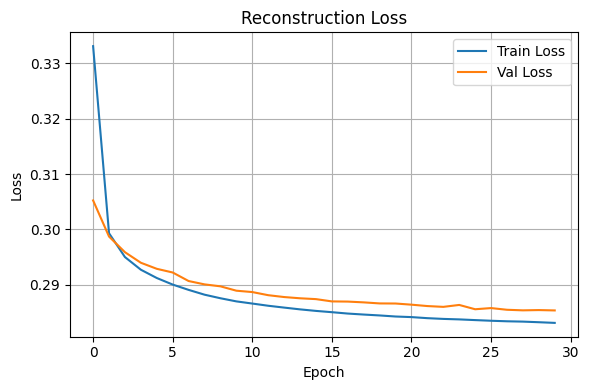

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

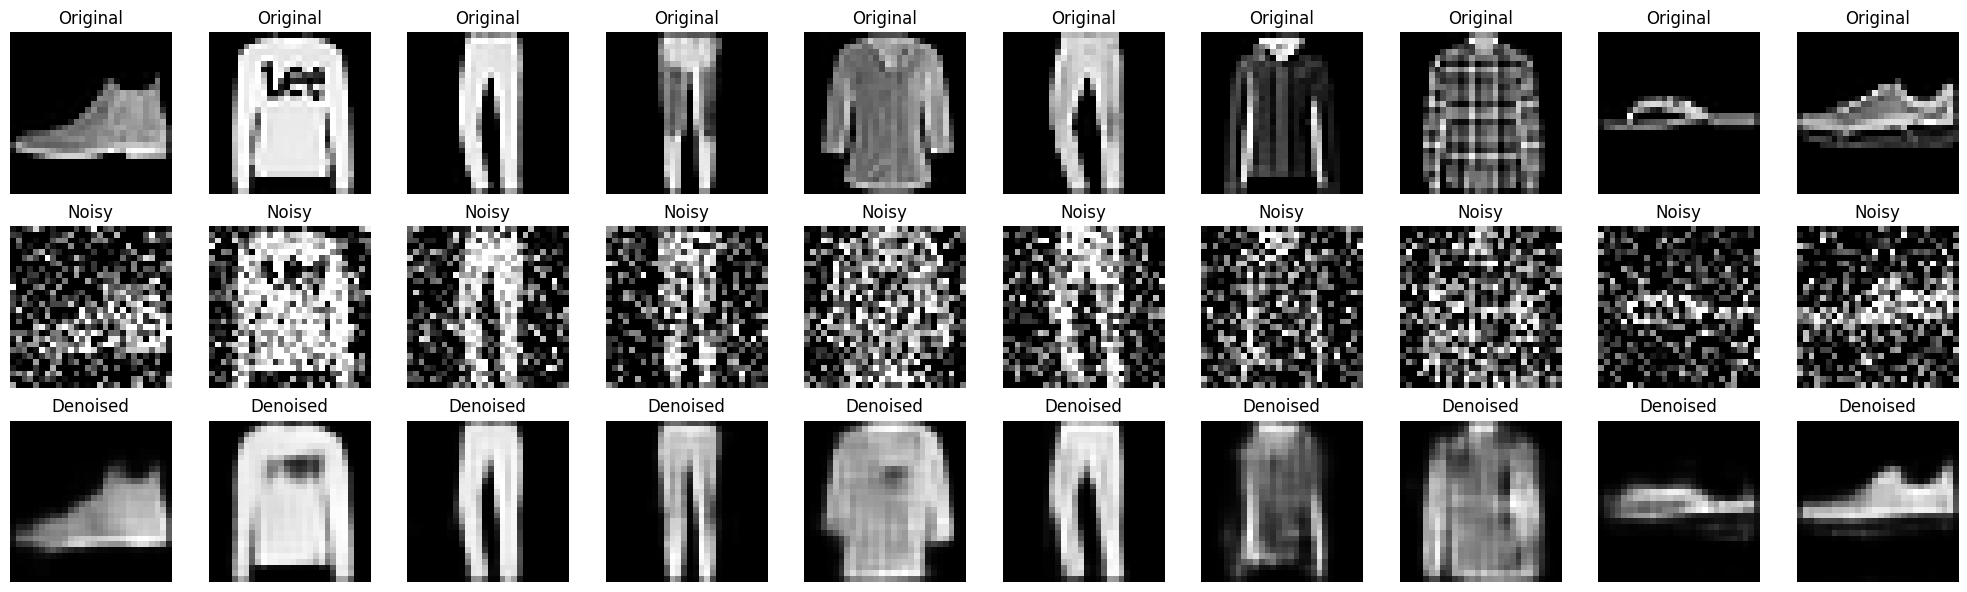

In [9]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()

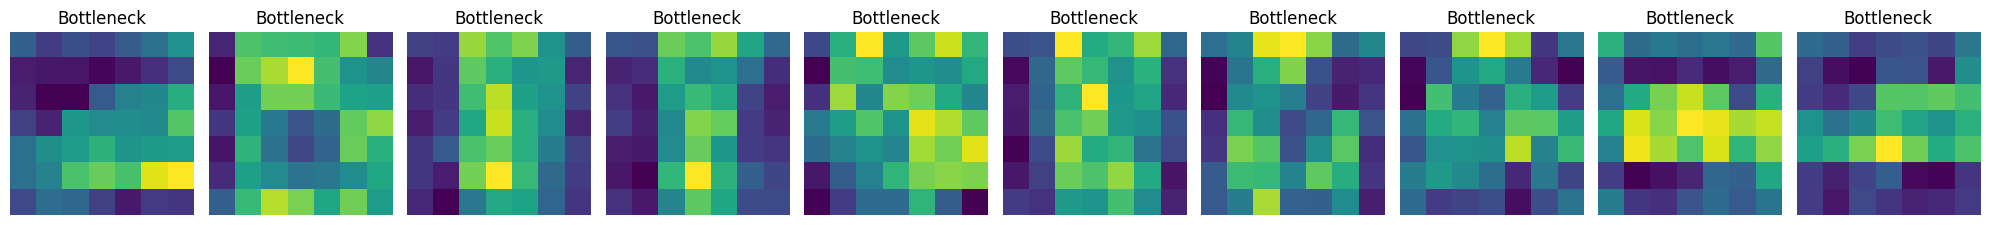

In [12]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    bottleneck_flat = np.mean(encoded_imgs[i], axis=-1)
    plt.imshow(bottleneck_flat, cmap='viridis')
    plt.title("Bottleneck")
    plt.axis('off')
plt.tight_layout()
plt.show()